In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr,spearmanr

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold


In [2]:
def read_obj(fname):
    s = fname.split("/")[-1].split(".")[0].split("_")
    for l in open(fname):
            return float(l.rstrip("\n")), int(s[2]), int(s[3])
        
def read_sol_sol(fname):
    s = fname.split("/")[-1].split(".")[0].split("_")
    for l in open(fname):
        if "Obj" in l:
            return float(l.rstrip("\n").split()[-1]),int(s[2]), int(s[3])
    print(fname)
        
def process_fname(fname):
    s = fname.split(".")[0].split("_")
    return int(s[2]), int(s[3])


def read_nohup(fname, best_obj):
    
    curr_fname = ""
    flag=False
    for line in open(fname):
        if line[:4] == "GTED":
            curr_fname = line.rstrip("\n")
            flag = False
            if "pan" not in line and "hylobates" not in line:
                flag = True
        try:
            if flag:
                iteration = int(line.rstrip().split()[0])
                time = line.rstrip().split()[-1]
    #             if iteration <= 100:
                score = float(line.rstrip().split()[1])
                if curr_fname != "":
                    best_obj[curr_fname] = (score, iteration,time)
        except:
            continue
    return best_obj

In [3]:
def get_emd(gteds_in):
    emds = []
    gteds = []
    groups = []
    for dist, i,j in gteds_in:
        if i== 0 and j == 0:
            emds.append(0)
            gteds.append(0)
        else:
            emd = emd_dist.loc[(i,j)]["dist"]
            if dist > emd:
                print(dist, emd, i,j)
                continue
            gteds.append(dist/100)
            emds.append(emd/100)
            groups.append(i // 10 % 5)
#             print(i)
    print("Total number:",len(emds))
    return emds, gteds, groups

In [4]:
def get_emd_bestobj(best_obj):
    gteds = []
    emds = []
    idx1 = []
    idx2 = []
    groups = []
    not_passed = []
    for n in best_obj:
        if n == "":
            continue
        i = int(n.split("_")[2])
        j = int(n.split("_")[3])
        emd = emd_dist.loc[(i,j)]["dist"]
        dist = best_obj[n][0]
        if dist > emd:
#             print(dist, emd, i, j )
            not_passed.append((i,j))
            continue
        gteds.append(dist/100)
        emds.append(emd/100)
        groups.append(i // 10 % 5)
        idx1.append(i)
        idx2.append(j)
    print("Passed:", len(emds))
    print("Not passed:",len(not_passed))
    return emds, gteds, idx1, idx2, groups, not_passed

In [16]:
## fit slope to diameter and discrepancy
def fit_sampled(df):
    x = np.array(df["sum Diameter"]).reshape(-1,1)
    y = df["(EMED - FGTED)"].to_numpy()
    
    fitted = LinearRegression().fit(x,y)
    coeff = fitted.coef_
    offset = fitted.intercept_
    return coeff, offset, fitted.score(x,y)

In [70]:
def k_fold_cross_val (gted_df, k=10):
    
    y = gted_df["(EMED - FGTED)"].astype(float).to_numpy()
    y_emed = gted_df["EMED"].astype(float).to_numpy()
    x_fgted = gted_df["FGTED"].astype(float).to_numpy()
    x = gted_df["sum Diameter"].astype(float).to_numpy()
    x = np.array(x).reshape(-1,1)
    
    mse = []
    corr = []
    prev_mse = []
    prev_corr = []
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]    
        fgted_test = x_fgted[test_index]
        emed_test = y_emed[test_index]
        reg = LinearRegression().fit(x_train, y_train)
        y_pred = reg.predict(x_test)
        m = np.mean([abs(a-b) for a,b in zip(emed_test, fgted_test + y_pred)])
        pm = np.mean([abs(a-b) for a,b in zip(emed_test, fgted_test)])
#         print(m,pm, reg.score(x_train, y_train))
        mse.append(m)
        prev_mse.append(pm)
        
        c = pearsonr(emed_test, fgted_test+y_pred)
        prev_c = pearsonr(emed_test, fgted_test)
        print(c, prev_c)
        corr.append(c[0])
        prev_corr.append(prev_c[0])
        
    # print(mse)
    print("Mean abs deviation: %f" % np.mean(mse))
    print("Mean prev abs deviation: %f" % np.mean(prev_mse))
    print("Mean correlation: %f" % np.mean(corr))    
    print("Mean prev correlation: %f" % np.mean(prev_corr))    

In [5]:

## Read all nohup files that contain gurobi output
best_obj = dict()
nohup_dir = "HBV_fgted_logs"
for f in os.listdir(nohup_dir):
    best_obj = read_nohup(f, best_obj)

In [7]:
dictt={"human":0,"bat":1,"duck":2}
matrix_gted = [[[] for i in range(3)] for j in range(3)]
matrix_emed = [[[] for i in range(3)] for j in range(3)]

In [8]:
## read computed EMED
emed_df = pd.read_csv("HBV_all_EMED.csv").set_index(["first","second"])

In [9]:
# read sample diameter
diameter_file = "HBV_sampled_diameters.txt"
diameter_df = pd.read_csv(diameter_file, sep=" ").set_index("Graphidx")
print(len(diameter_df.index))

9


In [11]:
first = []
second = []
gted = []
emeds = []
same = []
kinds = []
sum_diameters = []
for k in best_obj:
    if "pan" not in k and "hylobates" not in k:
        key1 = k.split("_")[2]+"_"+k.split("_")[3]
        key2 = k.split("_")[4]+"_"+k.split("_")[5]
        emed = emed_df.loc[(key1,key2), "dists"]

        if int(best_obj[k][2][:-1]) < 20000:
            first.append(key1)
            second.append(key2)
            gted.append(best_obj[k][0]/100)
            emeds.append(emed/100)
            kinds.append(",".join(sorted((k.split("_")[2], k.split("_")[4]))))
            try:
                sum_diameters.append(diameter_df.loc[key1,"Diameter"] + diameter_df.loc[key2,"Diameter"])
            except:
                sum_diameters.append(0)

gted_emed_df = pd.DataFrame(np.array([first, second, gted, emeds,kinds, sum_diameters]).T, columns = ["spc1","spc2","FGTED", "EMED", "Species Pair", "sum Diameter"])

In [15]:
gted_emed_df["(EMED - FGTED)"] = gted_emed_df["EMED"].astype("float") - gted_emed_df["FGTED"].astype("float")
gted_emed_df.loc[:,"EMED"] = gted_emed_df["EMED"].astype(float)
gted_emed_df.loc[:,"FGTED"] = gted_emed_df["FGTED"].astype(float)
gted_emed_df.loc[:,"sum Diameter"] = gted_emed_df["sum Diameter"].astype(float)/100

In [17]:
coef, intercept, r = fit_sampled(gted_emed_df)
gted_emed_df["corrected FGTED"] = gted_emed_df["FGTED"] + coef * gted_emed_df["sum Diameter"] + intercept
print("Fitted slope: %f, fitted offset: %f, R^2: %f" % (coef, intercept,r))    

Fitted slope: 0.042892, fitted offset: 108.897972, R^2: 0.016565


In [78]:
k_fold_cross_val(gted_df, k=10)

(0.8721966702529994, 2.9179791394581457e-36) (0.6772666741729454, 1.7756809424503987e-16)
(0.9259658565775662, 2.4403627490030602e-48) (0.8096297423342453, 3.2759745983927565e-27)
Mean abs deviation: 8.495127
Mean prev abs deviation: 32.703612
Mean correlation: 0.899081
Mean prev correlation: 0.743448


## For TCR

In [21]:
emd_dist = pd.read_csv("TCR_all_EMED.csv")
emd_dist = emd_dist.set_index(["set1","set2"])

In [22]:
nohup_dir1 = "TCR_fgted_logs/"

best_obj1 = dict()
nohups = [f for f in os.listdir(nohup_dir1) if ".out" in f]
for f in nohups:
    nohup_fname = nohup_dir1 + f
    best_obj1 = read_nohup(nohup_fname, best_obj1)

In [23]:
emds1, gteds1, idx1, idx2, groups1, not_passed1 = get_emd_bestobj(best_obj1)

Passed: 225
Not passed: 0


In [24]:
pl = sns.color_palette("viridis")

In [25]:
gted_df = pd.DataFrame(np.array([emds1, gteds1, idx1, idx2, groups1]).T, columns=["EMED", "FGTED", "idx1", "idx2","Group"])
gted_df["(EMED - FGTED)"] = (gted_df["EMED"] - gted_df["FGTED"])

In [27]:
diameter_df = pd.read_csv("TCR_sampled_diameters.txt", sep="\t")
diameter_df = diameter_df.set_index("Graph idx")

In [28]:
gted_df = gted_df.set_index(["idx1","idx2"])

In [29]:
sum_diameters = []
for i,j in gted_df.index:
    sum_dia = diameter_df.loc[i]["Diameter"] + diameter_df.loc[j]["Diameter"]
    sum_diameters.append(sum_dia/100)

In [31]:
gted_df["sum Diameter"] = sum_diameters

In [32]:
coeff, offset,r = fit_sampled(gted_df)
print(coeff, offset,r)
gted_df["corrected"] = gted_df["FGTED"] + gted_df["sum Diameter"] * coeff + offset

[0.29860373] -18.490028387620853 0.5034441177662589


In [33]:
k_fold_cross_val(gted_df, k=10)

6.051272043416008 26.5270772173913 0.5013556494170066
6.625871023032454 36.993715869565214 0.4968850141196284
5.175998139084913 31.329827391304345 0.49875607796252386
9.243393812011254 45.01914243478261 0.4432482827062709
11.768640566977986 14.958235782608693 0.50632141317802
21.700493506213455 15.976847863636362 0.6529166291064596
5.2409343891036855 33.232969 0.5050806640018418
9.009671468980564 47.518503954545444 0.45827785847889957
8.994370788593564 30.921648818181822 0.5059914159432888
7.455831422027129 44.88777713636364 0.47802536243574284
Mean abs deviation: 9.126648
Mean prev abs deviation: 32.736575


## Plots

In [ ]:
# sample half of hbv, fit LR, test on the other half
hbv_sampled_df = gted_emed_df.sample(frac=0.5)
hbv_test_df = gted_emed_df.drop(hbv_sampled_df.index)

coef, intercept, r = fit_sampled(hbv_sampled_df)
hbv_test_df["corrected FGTED"] = hbv_test_df["FGTED"] + coef * hbv_test_df["sum Diameter"] + intercept
print(r)

In [62]:
# sample half of tcr, fit LR, test on the other half
tcr_sampled_df = gted_df.sample(frac=0.5)
tcr_test_df = gted_df.drop(tcr_sampled_df.index)

coef, intercept, r = fit_sampled(tcr_sampled_df)
tcr_test_df["corrected FGTED"] = tcr_test_df["FGTED"] + coef * tcr_test_df["sum Diameter"] + intercept
print(r)

Error: IPyKernel not installed into interpreter Python 3.9.1 64-bit:/opt/local/bin/python3.9

In [63]:
np.mean(abs(tcr_test_df["corrected FGTED"] - tcr_test_df["EMED"]))

9.061355321869005

In [64]:
np.mean(abs(hbv_test_df["corrected FGTED"] - hbv_test_df["EMED"]))

53.209706763893905

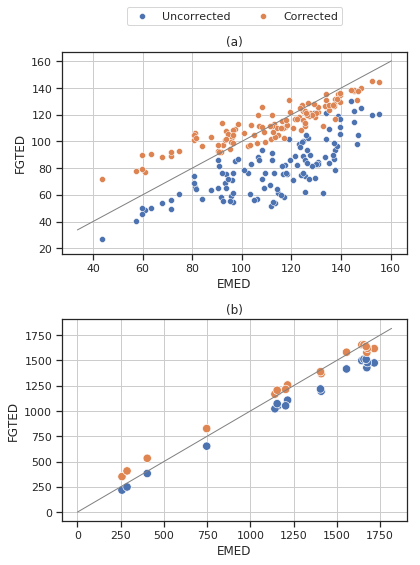

In [67]:
fig, axes = plt.subplots(2,1)

sns.set(font_scale=1)
sns.set_style("ticks",)
orange = (0.87, 0.52, 0.32)


minmax = [min(tcr_test_df["EMED"])-10, max(tcr_test_df["EMED"])+5]
sns.lineplot(x=minmax,y=minmax,color="grey", ax=axes[0], linewidth=1,legend=True)
sns.scatterplot(data=tcr_test_df, x="EMED", y="FGTED",label="Uncorrected", legend=True, ax=axes[0])
sns.scatterplot(data=tcr_test_df, x="EMED", y="corrected", label="Corrected", legend=True, ax=axes[0])

minmax = [0, max(hbv_test_df["EMED"])+100]
sns.lineplot(x=minmax,y=minmax,color="grey", ax=axes[1], linewidth=1,legend=False)
a = sns.scatterplot(data=hbv_test_df, x="EMED", y="FGTED",ax=axes[1],hue="size",s=70,legend=False,label="Uncorrected")
c = sns.scatterplot(data=hbv_test_df, x="EMED", y="corrected FGTED",label="Corrected",legend=False,ax = axes[1],s=70,palette=[orange],hue="size2")

# aa = axes[1].legend_.texts[1]
# bb = axes[1].legend_.legendHandles
axes[0].legend(bbox_to_anchor=(0.5, 1.25),loc='upper center', ncol=2)
# axes[1].legend(bb,aa, ncol=2,bbox_to_anchor=(0.5, 1.25),loc='upper center')


axes[0].set_title("(a)")
axes[1].set_title("(b)")

axes[0].grid()
axes[1].grid()

fig.set_size_inches(6,8)
fig.tight_layout()

fig.savefig("GTED_EMED.pdf")